# Run inference on pre-trained model:

In [1]:
import matplotlib.pyplot as plt
import torch

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from grace.io.image_dataset import ImageGraphDataset
from grace.models.feature_extractor import FeatureExtractor

from grace.evaluation.inference import GraphLabelPredictor
from grace.visualisation.manifold import TSNEDimensionalityReduction
from grace.visualisation.plotting import (
    plot_simple_graph,
    read_patch_stack_by_label, 
    montage_from_image_patches,
    overlay_from_image_patches,
)

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <6A7076EE-85BD-37A7-BC35-1D4867F2B3D3> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch_ge

### Read some real grace-annotated data:

In [3]:
bbox_size = (224, 224)
extractor_filename = "/Users/kulicna/Desktop/classifier/extractor/resnet152.pt"
pre_trained_resnet = torch.load(extractor_filename)
feature_extractor = FeatureExtractor(model=pre_trained_resnet, bbox_size=bbox_size)


In [4]:
grace_path = "/Users/kulicna/Desktop/dataset/shape_stars/train"
# grace_path = "/Users/kulicna/Desktop/dataset/shape_stars/infer"

dataset = ImageGraphDataset(
    image_dir=grace_path, 
    grace_dir=grace_path, 
    transform=feature_extractor,
    keep_node_unknown_labels=True, 
    keep_edge_unknown_labels=True, 
)

In [5]:
image, graph_data = dataset[1]
# image, graph_data = dataset[0]

G = graph_data["graph"]
image = image.numpy()
annot = graph_data["annotation"]
G.number_of_nodes(), G.number_of_edges(), annot.shape, image.shape 

09/13/2023 11:31:05 AM MRC_Synthetic_File_001
09/13/2023 11:31:05 AM Nodes count | [56, 84, 38] x | [31.46, 47.19, 21.35] %
09/13/2023 11:31:05 AM Edges count | [204, 100, 211] x | [39.61, 19.42, 40.97] %
[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(

(178, 515, (3724, 3724), (3724, 3724))

### Visualise the data:

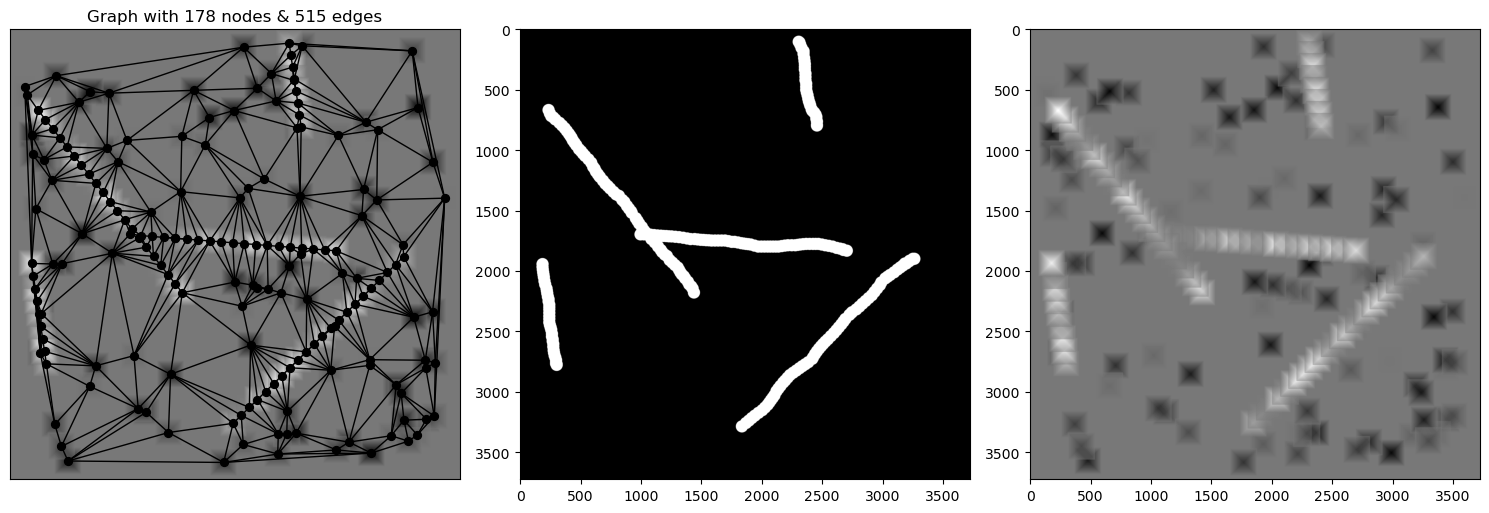

In [6]:
shape = 5
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(shape*3, shape*1))

plot_simple_graph(G, title=f"Graph with {G.number_of_nodes()} nodes & {G.number_of_edges()} edges", ax=axes[0])
axes[0].imshow(image, cmap="binary_r")
axes[1].imshow(annot, cmap="binary_r")
axes[2].imshow(image, cmap="binary_r")

plt.tight_layout()
plt.show()

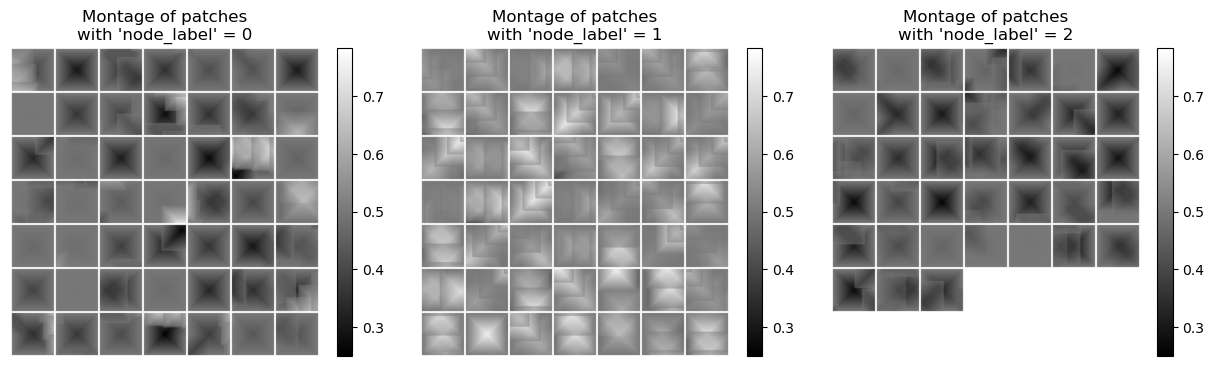

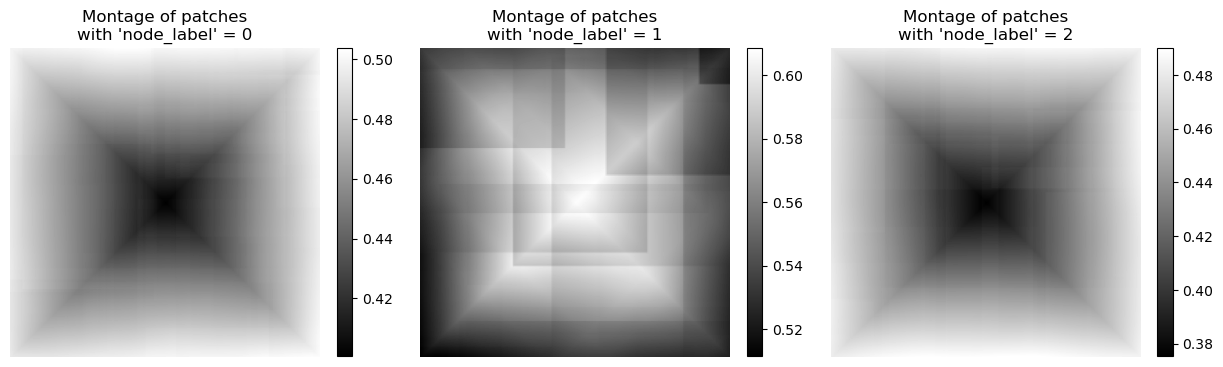

In [7]:
crops = read_patch_stack_by_label(G, image=image, crop_shape=bbox_size)
montage_from_image_patches(crops)
overlay_from_image_patches(crops)

### Nominate a pre-trained GCN model:

In [11]:
classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-08_15-11-58/classifier.pt"  # bad GCN + Linear classifier
# classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-07_17-30-51/classifier.pt"  # best Linear classifier
classifier_filename


'/Users/kulicna/Desktop/classifier/runs/2023-09-08_15-11-58/classifier.pt'

### Perform TSNE before & after GCN:

09/13/2023 11:33:36 AM Processing the model time-stamp: '2023-09-08_15-11-58/classifier.py'
09/13/2023 11:33:36 AM Extracted 'node_embeddings' -> torch.Size([178, 16]), torch.float32


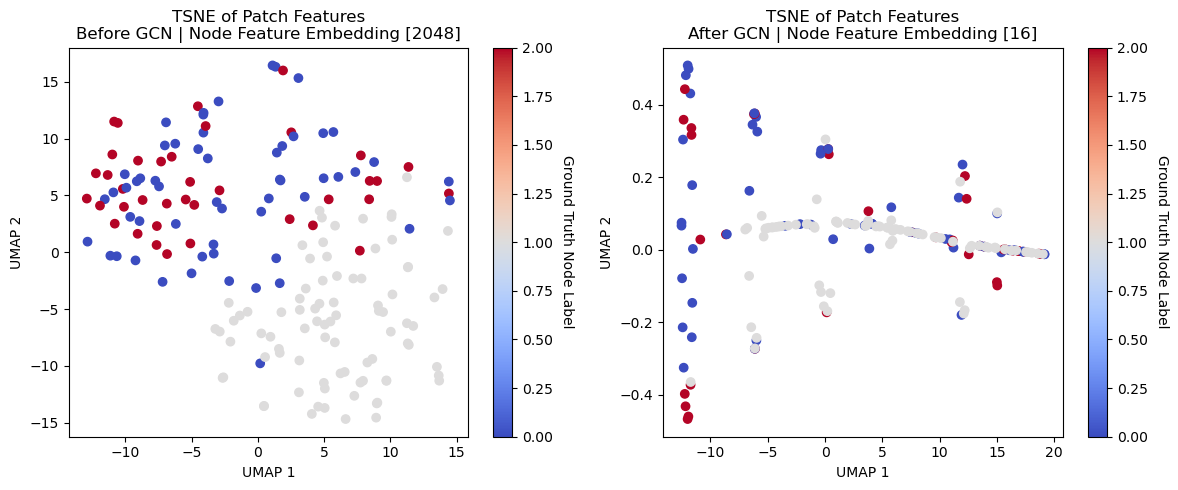

In [12]:
dim_red = TSNEDimensionalityReduction(graph=G, model=classifier_filename)
dim_red.plot_TSNE_before_and_after_GCN()

### Show how well the classifier performs:

Predicting for the entire graph: 100%|██████████| 1/1 [00:00<00:00, 270.18it/s]


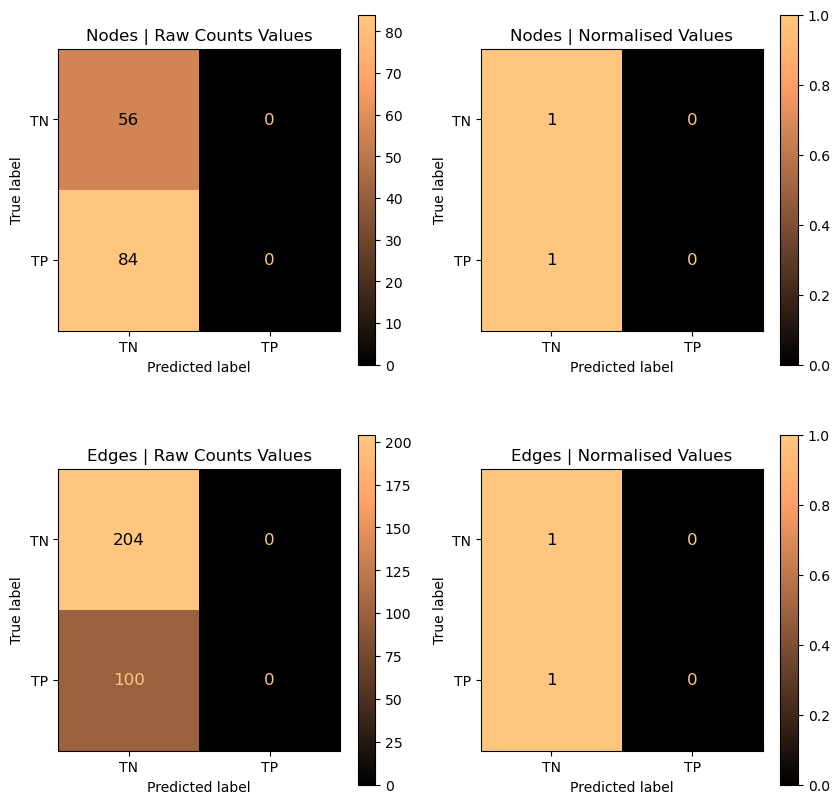

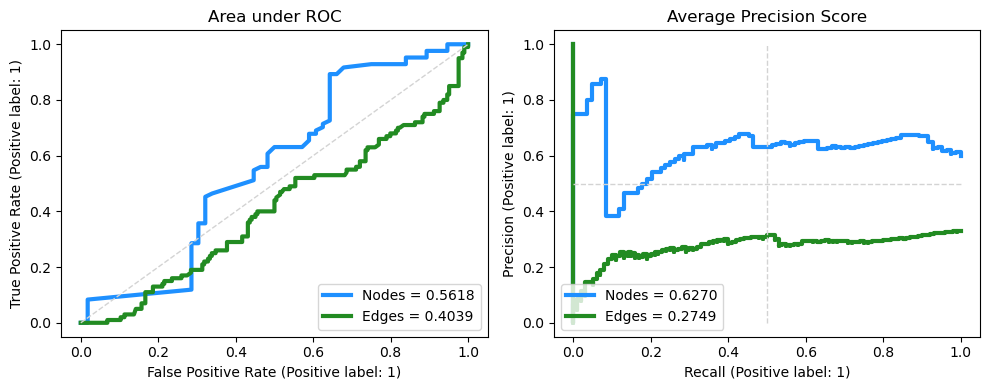

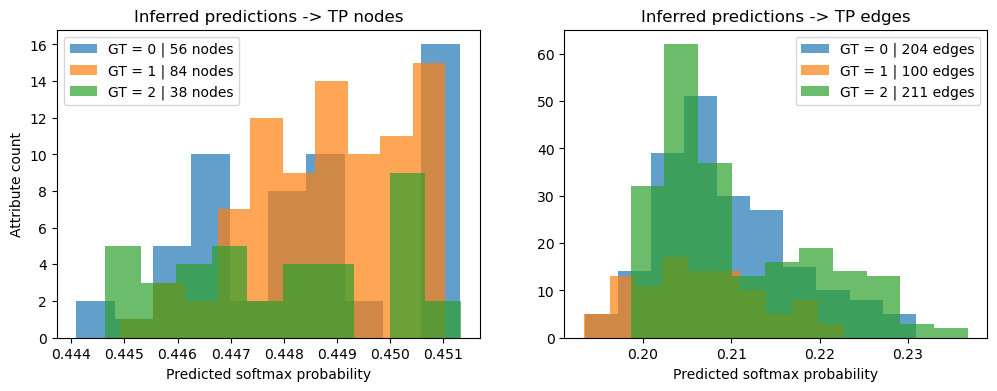

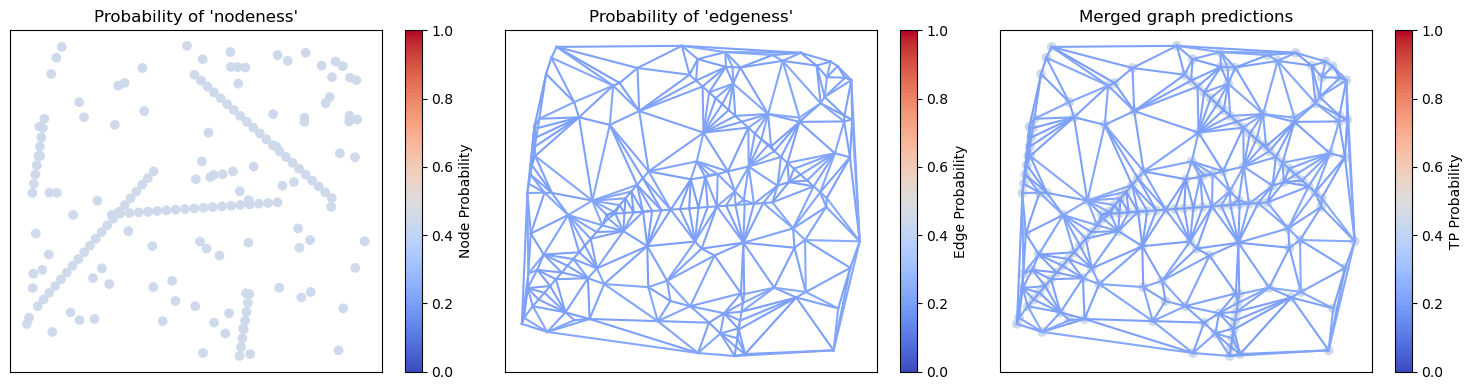

Node accuracy = 0.4000 | Edge accuracy = 0.6711


In [13]:
GLP = GraphLabelPredictor(model=classifier_filename)
GLP.set_node_and_edge_probabilities(G=G)
node_acc, edge_acc = GLP.visualise_model_performance_on_graph(G=G)
print(f"Node accuracy = {node_acc:.4f} | Edge accuracy = {edge_acc:.4f}")

##### Done!